In [1]:
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import numpy as np

def load_images_from_directory(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (150, 150)) 
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)


real_images_dir = 'C:/Users/Dell/OneDrive/Desktop/fake image detction/real'
fake_images_dir = 'C:/Users/Dell/OneDrive/Desktop/fake image detction/fake'

real_images, real_labels = load_images_from_directory(real_images_dir, label=0)
fake_images, fake_labels = load_images_from_directory(fake_images_dir, label=1)


all_images = np.concatenate((real_images, fake_images), axis=0)
all_labels = np.concatenate((real_labels, fake_labels), axis=0)


shuffle_indices = np.random.permutation(len(all_images))
all_images = all_images[shuffle_indices]
all_labels = all_labels[shuffle_indices]

################ 
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_split = int(train_ratio * len(all_images))
val_split = int((train_ratio + val_ratio) * len(all_images))

X_train = all_images[:train_split]
y_train = all_labels[:train_split]

X_val = all_images[train_split:val_split]
y_val = all_labels[train_split:val_split]

X_test = all_images[val_split:]
y_test = all_labels[val_split:]


X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

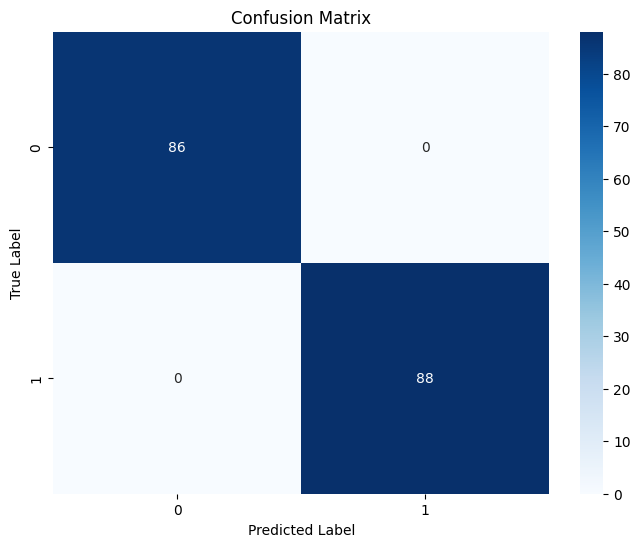

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00        88

    accuracy                           1.00       174
   macro avg       1.00      1.00      1.00       174
weighted avg       1.00      1.00      1.00       174



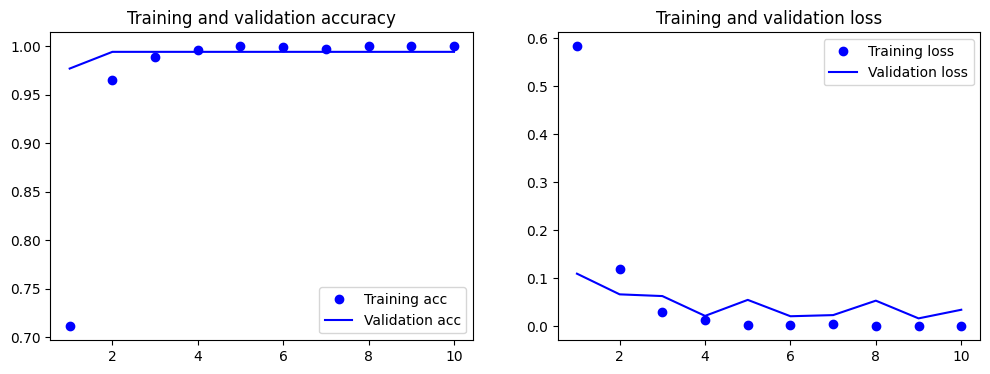

C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# architecture #

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

##### Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Predict the labels for the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

#### training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('fake_image_classifier_model.h5')


# Example usage of the trained model

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
###############################################################################################

def preprocess_image(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Resize the image to a fixed size (e.g., 150x150 pixels)
    image = cv2.resize(image, (150, 150))
    
    # Convert the image to RGB color space (if it's in BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Normalize pixel values to range [0, 1]
    image = image.astype('float32')/ 255.0
    
    # Expand dimensions to add batch dimension
    image = np.expand_dims(image, axis=0)
    
    return image

def predict_image(image_path):
    model = tf.keras.models.load_model('fake_image_classifier_model.h5')
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    if prediction[0][0] > 0.5:
        return "Fake"
    else:
        return "Real"


In [ ]:
# Test the model on a new image
new_image_path = '/Users/Dell/OneDrive/Desktop/fake image detction/testfake/aifake.jpg'  # Replace with the path to your new image
prediction = predict_image(new_image_path)
print(f'Prediction for {new_image_path}: {prediction}')